In [1]:
import numpy as np
import pandas as pd
import statistics as stat

import plotly.plotly as py
import plotly.figure_factory as ff

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import gridspec
from collections import Counter

sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
dfs_orig_results = pd.read_csv(
    './../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0
)
clinical = pd.read_excel('./../../data_source/clinical/clinical_params.xlsx', index_col=0)

In [3]:
clinical = clinical.loc[dfs_orig_results.index, :]
clinical.shape

(198, 13)

In [4]:
list(clinical.columns)

['Alder',
 'Kjønn',
 'ICD10 kort',
 'T-klassifisering',
 'N-klassifisering',
 'Stadium',
 'Histologi',
 'HPV-status',
 'ECOG',
 'Charlson',
 'Pakkeår',
 'Naxogin dager',
 'Cisplatin']

# Pair Plot Numerical Variables

<Figure size 1080x1080 with 0 Axes>

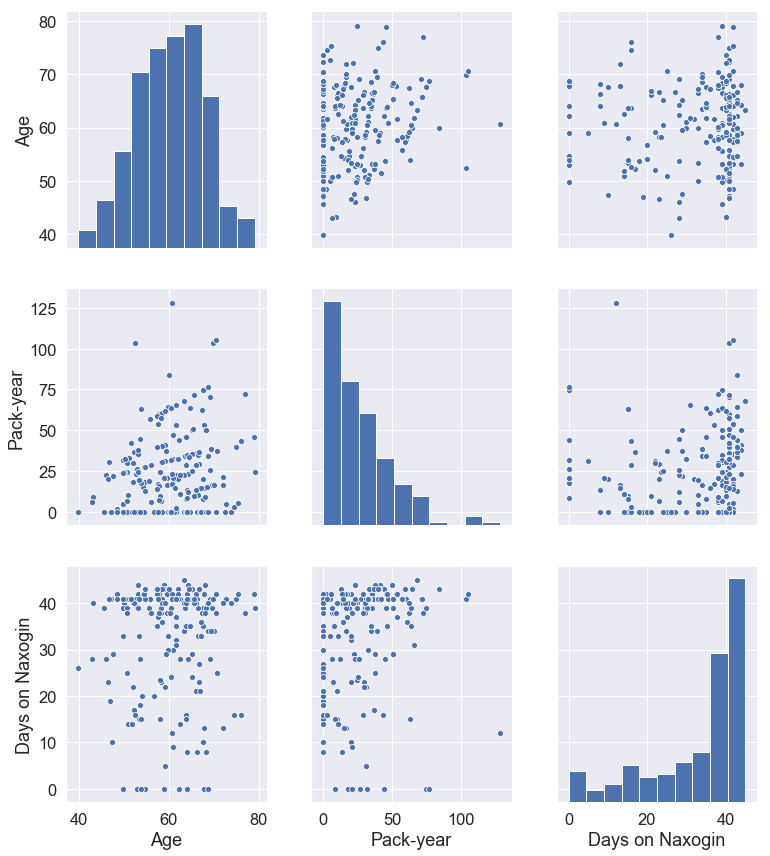

In [5]:
numerical_clinical = ['Alder', 'Pakkeår', 'Naxogin dager']
clin_num = clinical.loc[:, numerical_clinical]
clin_num.columns = ['Age', 'Pack-year', 'Days on Naxogin']

plt.figure(figsize=(15, 15))
sns.pairplot(data=clin_num, height=4, aspect=0.9)
plt.tight_layout()
plt.savefig(
    './../../figures/expl_analysis/clinical_num_pairplot.png',
    bbox_inches='tight',
    dpi=100, 
)

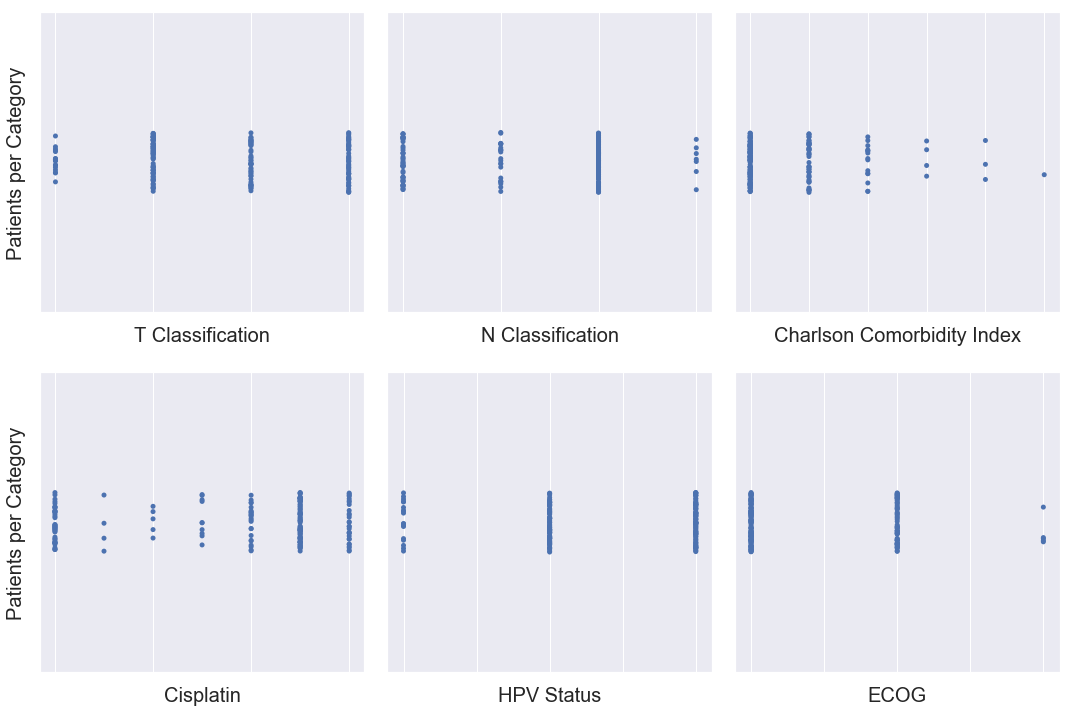

In [13]:
keys = [
    'T-klassifisering', 'N-klassifisering', 'Charlson', 'Cisplatin', 'HPV-status', 'ECOG'
]
labels = [
    'T Classification', 'N Classification', 'Charlson Comorbidity Index', 'Cisplatin', 
    'HPV Status', 'ECOG'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=True)
for num, axis in enumerate(axes.ravel()):
    data = clinical.loc[:, keys[num]]
    x_coords = np.unique(data)
    if x_coords[0] == 1:
        data = data - 1
    
    sns.stripplot(x=data, ax=axis)
    axis.set_ylabel('')
    axis.set_xlabel(f'{labels[num]}', fontsize=20)
    #axis.set_xticks(np.arange(np.size(x_coords)))
    #axis.set_xticklabels(x_coords, fontsize=17)
    axis.set_xticklabels([])
    for patch in axis.patches :
        patch.set_width(0.4)

axes[0, 0].set_ylabel('Patients per Category', fontsize=20)
axes[1, 0].set_ylabel('Patients per Category', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig(
    './../../figures/expl_analysis/clinical_categorical_distr.png',
    bbox_inches='tight',
    dpi=100, 
)

# HPV & OPC

In [16]:
opc = pd.read_excel('./../../data_source/clinical/ops.xlsx', index_col=0)
opc = opc.loc[dfs_orig_results.index, :]
opc = np.squeeze(opc.values)

hpv = np.squeeze(clinical.loc[:, 'HPV-status'].values)

In [17]:
hpv_opc = {
    'opc_hpv': 0, 'not_opc_hpv': 0, 'opc_not_hpv': 0, 'not_opc_not_hpv': 0
}
for num, (_hpv, _opc) in enumerate(zip(hpv, opc)):
    if _hpv == 1 and _opc == 1:
        hpv_opc['opc_hpv'] += 1
    elif _hpv == 1 and _opc == 0:
        hpv_opc['not_opc_hpv'] += 1
    elif _hpv == 0 and _opc == 1:
        hpv_opc['opc_not_hpv'] += 1
    else:
        hpv_opc['not_opc_not_hpv'] += 1
        
series_hpv_opc = pd.Series(hpv_opc, index=hpv_opc.keys())

In [18]:
hpv_opc = pd.DataFrame([hpv, opc], index=['HPV', 'OPC'])

In [19]:
np.unique(clinical['Histologi']), np.bincount(clinical['Histologi'])

(array([0., 1., 2., 3.]), array([138,  50,   9,   1]))

In [53]:
198 - np.sum(hpv_opc.loc['HPV', :] == 2) -  np.sum(hpv_opc.loc['HPV', :] == 1)

18

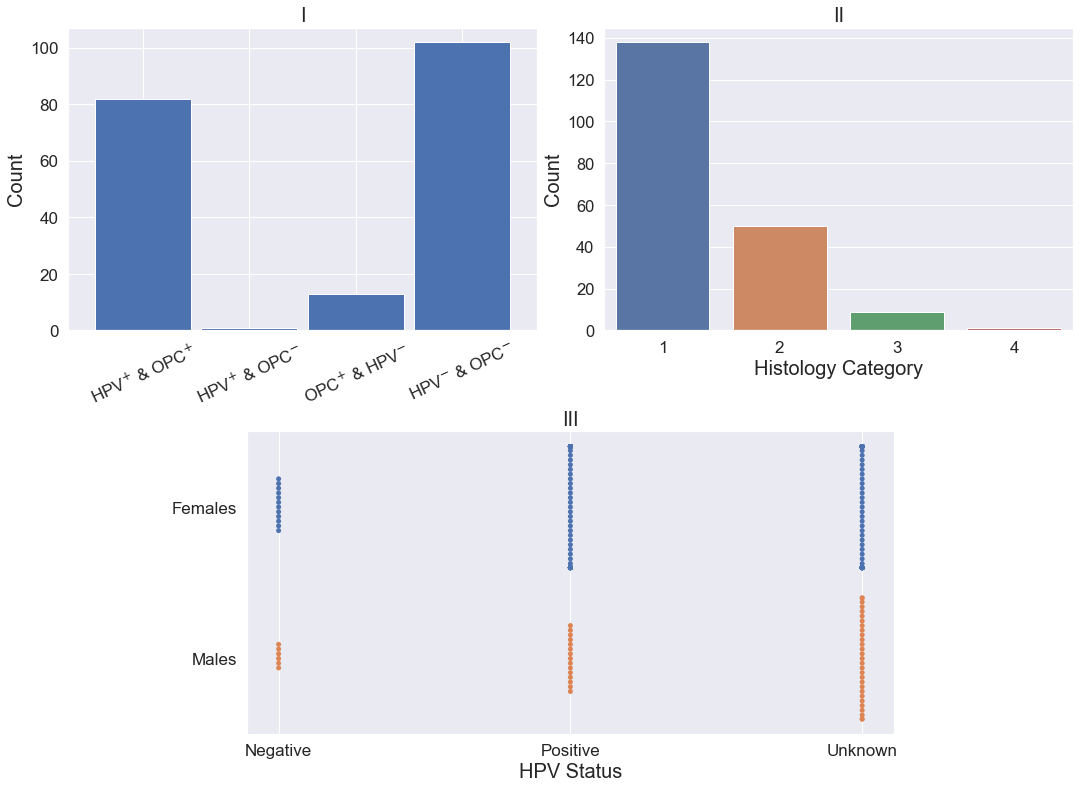

In [33]:
plt.figure(figsize=(18, 13))
gs = gridspec.GridSpec(4, 6)
axis1 = plt.subplot(gs[:2, :3])
axis2 = plt.subplot(gs[:2, 3:])
axis3 = plt.subplot(gs[2:4, 1:5])

series_hpv_opc.plot(kind='bar', ax=axis1, width=0.9)

axis1.set_title('I', fontsize=20)
axis1.set_ylabel('Count', fontsize=20)
axis1.tick_params(axis='both', which='major', labelsize=17)
axis1.set_xticklabels(
    [r'HPV$^{+}$ & OPC$^{+}$', r'HPV$^{+}$ & OPC$^{-}$', r'OPC$^{+}$ & HPV$^{-}$', r'HPV$^{-}$ & OPC$^{-}$'], 
    rotation=25,
    fontsize=17
)
sns.countplot(
    x='Histologi',
    data=clinical,
    ax=axis2
)
axis2.set_title('II', fontsize=20)
axis2.set_xticklabels(np.arange(4) + 1, fontsize=17)
axis2.set_xlabel('Histology Category', fontsize=20)
axis2.set_ylabel('Count', fontsize=20)


axis3.set_title('III', fontsize=20)
sns.swarmplot(y='Kjønn', x='HPV-status', data=clinical)#ax=axis3, , ci=None, linewidth=2)
axis3.set_yticklabels(['Females', 'Males'], fontsize=17)
axis3.set_xticks([0, 1, 2])
axis3.set_xticklabels(['Negative', 'Positive', 'Unknown'], fontsize=17)
axis3.set_ylabel('')
axis3.set_xlabel('HPV Status', fontsize=20)

plt.subplots_adjust(wspace=0.6, hspace=1)

plt.savefig(
    './../../figures/expl_analysis/opc_vs_hpv.png',
    bbox_inches='tight',
    dpi=100
)

In [ ]:
sum(clinical.loc[:, 'HPV-status'] == 0), sum(clinical.loc[:, 'HPV-status'] == 1), sum(clinical.loc[:, 'HPV-status'] == 2)

# Patient Outcome Distributions

In [18]:
v1 = np.squeeze(dfs_orig_results.values)
print('No information rate', max([1 - sum(v1) / v1.size, sum(v1) / v1.size, ]))

No information rate 0.6767676767676767
